# Using BERT to Identify Bill Hardy (Binary Classification)

## Classification of the Pages

Now that K-means clustering seems to indicate that some of the narrators can be inferred from the pages, we can attempt to use a language model to predict whether a page belongs to a given narrator. 

Let's start with a binary classification to **predict if sentences belong or not to Bill Hardy**.

<img src="https://glthr.com/cj/characters/bill-min.jpg" alt="drawing" width="400"/>

In [1]:
%%capture

# make logs less verbose
import os

os.environ["TF_CPP_MIN_LOG_LEVEL"] = "2"

# suppress UnparsedFlagAccessError warning
import sys
from absl import flags

sys.argv = ["preserve_unused_tokens=False"]
flags.FLAGS(sys.argv)

# suppress warnings
# (after having ensured they did not impact the analysis)
import warnings

warnings.filterwarnings("ignore")

## Process data

In [2]:
import pandas as pd

df = pd.read_json("./data/jawbone.json")

Augment the data with the label: `True` for Bill Hardy, `False` otherwise.

In [3]:
import json

f = open("./data/unofficial_solution.json")
possible_solutions = json.load(f)
f.close()


def is_bill(id):
    for key, ids in possible_solutions.items():
        if id in ids:
            return key == "Bill Hardy"
    return None


df = df.astype({"text": "string"})
df["is_Bill"] = df["page"].apply(lambda x: is_bill(x))
df

,page,text,is_Bill
0,1,I sit down alone at the appointed table and ta...,True
1,2,I plunged for the last time. The few remaining...,False
2,3,"At my meeting with Clement yesterday, he had b...",False
3,4,And I really think I would have preferred the ...,True
4,5,I hated my eye for being caught by what didn’t...,False
...,...,...,...
95,96,Now I think I will try a cup of what they inso...,True
96,97,To have slept and to wake right up surrounded ...,False
97,98,He stood and looked down at me; but I was not ...,False
98,99,"And she wore a mauve love-knot on her breast, ...",False


## Train BERT Model

In [4]:
import torch

# hyperparameters

num_epochs = 20
learning_rate = 2e-5
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [5]:
from transformers import BertTokenizer, BertForSequenceClassification
from transformers import logging

logging.set_verbosity_error()  # suppress untrained weight error (unconsequential)

# use BERT large uncased model
# https://huggingface.co/bert-large-uncased
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")
bert_model = BertForSequenceClassification.from_pretrained(
    "bert-base-uncased", num_labels=1
)

In [6]:
from sklearn.model_selection import train_test_split


def get_datasets(df):
    # sample 40% of the Bill pages/sentences and more than 25% of all pages/sentences
    df_bill = df[df["is_Bill"] == True].sample(frac=0.3)
    df_not_bill = df[df["is_Bill"] == False].sample(frac=0.3)

    df_sampled = pd.concat([df_bill, df_not_bill], axis=0)

    print(df_sampled)

    # split datasets
    return train_test_split(
        df_sampled["text"].values,
        df_sampled["is_Bill"].values,
        test_size=0.2,
        random_state=42,
    )


train_texts, test_texts, train_labels, test_labels = get_datasets(df)

print(f"Train dataset size: {train_texts.shape[0]}")
print(f"Test dataset size: {test_texts.shape[0]}")

    page                                               text  is_Bill
0      1  I sit down alone at the appointed table and ta...     True
22    23  I hate seeing things like this in the paper. B...     True
99   100  I dimly guess why the old dead so wanted this....     True
42    43  This is good. She accepts Lover’s Delight from...     True
8      9  The sound of the bell, as of a boding gnat, ju...    False
37    38  I was feeling better already, and was glad tha...    False
36    37  Death’s clumsy fingers, that was the really fr...    False
54    55  The picture of the Old Mill at Bramley, with i...    False
60    61  I had always been proud of my namesake, the Gr...    False
70    71  But next day that religious fellow’s head drap...    False
52    53  So far the mind had been ambling, if I may dar...    False
61    62  What should such a man need with such a compan...    False
43    44  I sometimes wish, and I wished then, that I ha...    False
30    31  The others did not seem 

In [7]:
from torch.utils.data import DataLoader, Dataset


# tokenize and prepare the input data
class TokenizedData(Dataset):
    def __init__(self, texts, labels, tokenizer, max_len=128):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = str(self.texts[idx])
        label = float(self.labels[idx])
        inputs = self.tokenizer(
            text,
            truncation=True,
            padding="max_length",
            max_length=self.max_len,
            return_tensors="pt",
        )
        return {
            "input_ids": inputs["input_ids"].flatten(),
            "attention_mask": inputs["attention_mask"].flatten(),
            "label": torch.tensor(label, dtype=torch.float32),
        }


train_dataloader = DataLoader(
    TokenizedData(train_texts, train_labels, tokenizer), batch_size=2, shuffle=True
)
test_dataloader = DataLoader(
    TokenizedData(test_texts, test_labels, tokenizer), batch_size=2, shuffle=False
)

In [8]:
from transformers import AdamW
import copy


def train(dataloader):
    model = copy.copy(bert_model)
    criterion = torch.nn.BCEWithLogitsLoss()
    optimizer = AdamW(model.parameters(), lr=learning_rate)

    model.to(device)

    for epoch in range(num_epochs):
        model.train()
        total_loss = 0.0

        for batch in dataloader:
            input_ids = batch["input_ids"].to(device)
            attention_mask = batch["attention_mask"].to(device)
            labels = batch["label"].squeeze().to(device)

            optimizer.zero_grad()
            outputs = model(input_ids, attention_mask=attention_mask)
            loss = criterion(outputs.logits.flatten(), labels)
            loss.backward()
            optimizer.step()

            total_loss += loss.item()

        avg_loss = total_loss / len(dataloader)
        print(f"{epoch + 1}/{num_epochs} — loss: {avg_loss:.4f}")

    return model


model = train(train_dataloader)

1/20 — loss: 0.6026
2/20 — loss: 0.4270
3/20 — loss: 0.2872
4/20 — loss: 0.1845
5/20 — loss: 0.1209
6/20 — loss: 0.0878
7/20 — loss: 0.0696
8/20 — loss: 0.0503
9/20 — loss: 0.0373
10/20 — loss: 0.0240
11/20 — loss: 0.0178
12/20 — loss: 0.0110
13/20 — loss: 0.0091
14/20 — loss: 0.0077
15/20 — loss: 0.0067
16/20 — loss: 0.0054
17/20 — loss: 0.0054
18/20 — loss: 0.0043
19/20 — loss: 0.0041
20/20 — loss: 0.0036


## Predict

In [9]:
from sklearn.metrics import accuracy_score


def eval(model, texts):
    model.eval()

    inputs = tokenizer(
        [text for text in texts],
        return_tensors="pt",
        truncation=True,
        padding=True,
    )
    input_ids = inputs["input_ids"].to(device)
    attention_mask = inputs["attention_mask"].to(device)

    with torch.no_grad():
        outputs = model(input_ids, attention_mask=attention_mask)

    probabilities = torch.sigmoid(outputs.logits).cpu().numpy()
    predicted_labels = (probabilities > 0.5).astype(int)

    return predicted_labels


predictions = eval(model, test_texts)
accuracy = accuracy_score(test_labels, predictions)
print(f"Validation accuracy: {accuracy:.4f}")

Validation accuracy: 1.0000


In [10]:
predicted_labels = eval(model, df.text.values)

Confusion matrix

<Figure size 800x600 with 0 Axes>

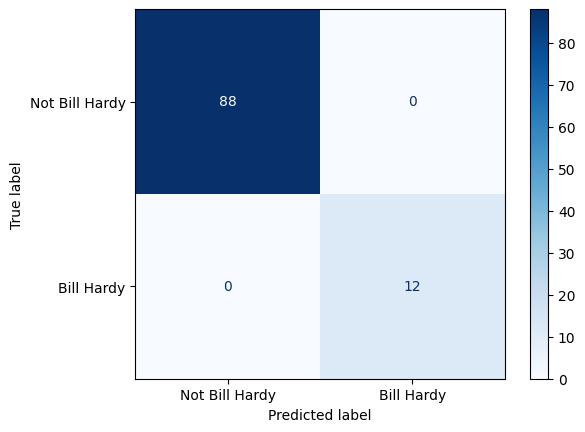

In [11]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay


def generate_confusion_matrix(model, df, predicted_labels):
    cm = confusion_matrix(df.is_Bill.values, predicted_labels)
    disp = ConfusionMatrixDisplay(
        confusion_matrix=cm, display_labels=["Not Bill Hardy", "Bill Hardy"]
    )

    plt.figure(figsize=(8, 6))
    disp.plot(cmap="Blues")

    plt.show()


generate_confusion_matrix(model, df, predicted_labels)

Identify misclassified pages

In [12]:
def identify_misclassified_items(df, predicted_labels, item_type):
    misclassified_indices = [
        i
        for i, (true, pred) in enumerate(zip(df.is_Bill.values, predicted_labels))
        if true != pred
    ]

    if len(misclassified_indices) == 0:
        print(f"No misclassified {item_type}")
        return

    print(f"Misclassified {item_type}:")
    for index in misclassified_indices:
        print(
            f"Expected narrator: {int(df.is_Bill.values[index])} — predicted narrator: {predicted_labels[index][0]} — [{df.page.values[index]}] {df.text.values[index]}"
        )


identify_misclassified_items(df, predicted_labels, "pages")

No misclassified pages


# Predicted Pages Representation

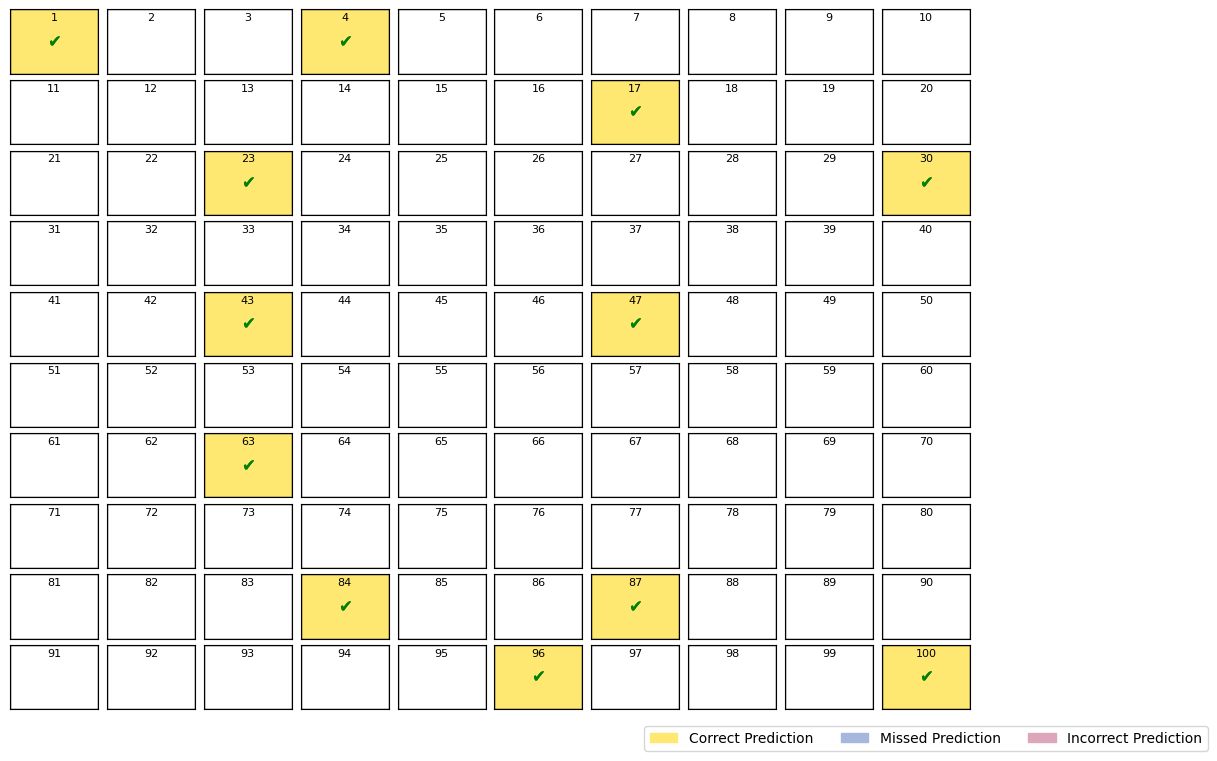

In [13]:
import matplotlib.patches as mpatches

cols, rows = 10, 10

expected_pages = [page - 1 for page in df[df["is_Bill"]]["page"].values.tolist()]
predicted_pages = [
    index for index, value in enumerate(predicted_labels.flatten()) if value == 1
]

fig, axs = plt.subplots(rows, cols, figsize=(cols, rows), tight_layout=True)

for i, ax in enumerate(axs.ravel()):
    ax.set_xticks([])
    ax.set_yticks([])
    ax.add_patch(
        plt.Rectangle((0, 0), 1, 1, fill=True, edgecolor="#000000", facecolor="#FFFFFF")
    )
    row, col = divmod(i, cols)
    ax.text(0.5, 0.95, str(i + 1), ha="center", va="top", color="#000000", fontsize=8)

common_indices = set.intersection(set(expected_pages), set(predicted_pages))

for index in expected_pages + predicted_pages:
    row, col = divmod(index, cols)

    if index in common_indices:
        # pages adequately predicted
        axs[row, col].patches[0].set_facecolor("#FFE871")
        axs[row, col].text(
            0.5, 0.5, "✔", ha="center", va="center", color="green", fontsize=12
        )
    elif index in expected_pages:
        # pages erroneously not predicted
        axs[row, col].patches[0].set_facecolor("#A6B7DE")
        axs[row, col].text(
            0.5, 0.5, "✘", ha="center", va="center", color="red", fontsize=12
        )
    else:
        # pages erroneously predicted
        axs[row, col].patches[0].set_facecolor("#DEA6BA")
        axs[row, col].text(
            0.5, 0.5, "✘", ha="center", va="center", color="red", fontsize=12
        )

plt.legend(
    handles=[
        mpatches.Patch(color="#FFE871", label="Correct Prediction"),
        mpatches.Patch(color="#A6B7DE", label="Missed Prediction"),
        mpatches.Patch(color="#DEA6BA", label="Incorrect Prediction"),
    ],
    loc="upper center",
    bbox_to_anchor=(0.5, -0.15),
    fancybox=True,
    ncol=3,
)

fig.set_size_inches(12, 10)
plt.subplots_adjust(top=0.9, bottom=0.2, left=0.1, right=0.9, hspace=0.1, wspace=0.1)

plt.show()

***

## Classification of the Sentences

In [14]:
# tokenize pages
import nltk
from nltk import sent_tokenize


def tokenize_sentences(paragraph):
    sentences = sent_tokenize(paragraph)

    valid_sentences = [
        sentence for sentence in sentences if any(c.isalnum() for c in sentence)
    ]
    return valid_sentences


df["text"] = df["text"].apply(tokenize_sentences)
df = df.explode("text").reset_index(drop=True)
df

,page,text,is_Bill
0,1,I sit down alone at the appointed table and ta...,True
1,1,"Call me nervous, call me fey, if you will; at ...",True
2,1,It has not had much work since it flew so nimb...,True
3,1,"As I watch the sea, Casy Ferris passes with do...",True
4,1,"Of course, to-day is the day.",True
...,...,...,...
1225,100,O beastly woman.,True
1226,100,"You know not how ill’s all here, about my hear...",True
1227,100,"Henry, I feel it, is for the first and last ti...",True
1228,100,"Good-bye, Henry.",True


In [15]:
train_texts, test_texts, train_labels, test_labels = get_datasets(df)

print(f"Train dataset size: {train_texts.shape[0]}")
print(f"Test dataset size: {test_texts.shape[0]}")

train_dataloader = DataLoader(
    TokenizedData(train_texts, train_labels, tokenizer), batch_size=20, shuffle=True
)
test_dataloader = DataLoader(
    TokenizedData(test_texts, test_labels, tokenizer), batch_size=20, shuffle=False
)

      page                                               text  is_Bill
1215   100  She lolls over at me gloating, her mouth blood...     True
1019    84          But wiseacres contend that it was Kismet.     True
583     47  We were sitting in the verandah in the dead, h...     True
1061    87                                     Why, I wonder?     True
189     17                                         I’m sorry.     True
...    ...                                                ...      ...
793     65  In that case, I thought I knew the type: learn...    False
156     13                                But one never knew.    False
910     76  And then arrived the blinding realisation that...    False
472     38  I was feeling better already, and was glad tha...    False
169     15  Yes, if sitting at the familiar table with Bar...    False

[369 rows x 3 columns]
Train dataset size: 295
Test dataset size: 74


In [16]:
model = train(train_dataloader)

1/20 — loss: 0.2357
2/20 — loss: 0.1392
3/20 — loss: 0.0739
4/20 — loss: 0.0503
5/20 — loss: 0.0335
6/20 — loss: 0.0230
7/20 — loss: 0.0156
8/20 — loss: 0.0120
9/20 — loss: 0.0101
10/20 — loss: 0.0079
11/20 — loss: 0.0079
12/20 — loss: 0.0068
13/20 — loss: 0.0058
14/20 — loss: 0.0040
15/20 — loss: 0.0026
16/20 — loss: 0.0020
17/20 — loss: 0.0013
18/20 — loss: 0.0011
19/20 — loss: 0.0009
20/20 — loss: 0.0009


In [17]:
predictions = eval(model, test_texts)

accuracy = accuracy_score(test_labels, predictions)
print(f"Validation accuracy: {accuracy:.4f}")

Validation accuracy: 0.9865


In [18]:
predicted_labels = eval(model, df.text.values)

<Figure size 800x600 with 0 Axes>

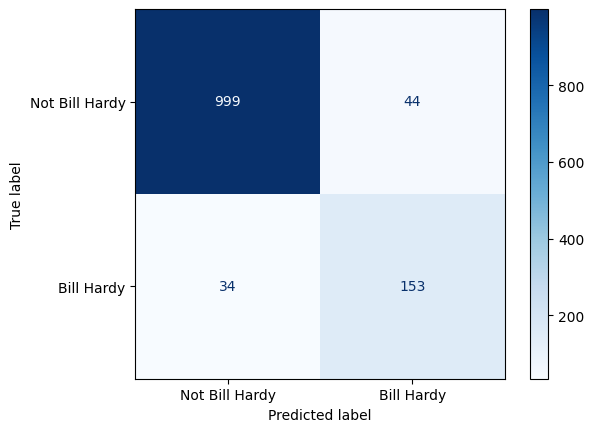

In [19]:
generate_confusion_matrix(model, df, predicted_labels)

In [20]:
identify_misclassified_items(df, predicted_labels, "sentences")

Misclassified sentences:
Expected narrator: 1 — predicted narrator: 0 — [1] But all the nice gulls love a sailor.
Expected narrator: 0 — predicted narrator: 1 — [3] My signs are a rain-proof coat, good shoes.
Expected narrator: 0 — predicted narrator: 1 — [3] I have no chair.
Expected narrator: 1 — predicted narrator: 0 — [4] But the queen can do no wrong.
Expected narrator: 1 — predicted narrator: 0 — [4] If she had said a mashie.
Expected narrator: 0 — predicted narrator: 1 — [9] They seem, as a class, to have absolutely no sense of responsibility .
Expected narrator: 0 — predicted narrator: 1 — [11] Very emotional.
Expected narrator: 0 — predicted narrator: 1 — [13] Weeps she in desert shades?
Expected narrator: 0 — predicted narrator: 1 — [13] Alas!
Expected narrator: 0 — predicted narrator: 1 — [16] Should I make an effort and go back to Henry?
Expected narrator: 1 — predicted narrator: 0 — [17] Conveniently situated for some things, that is.
Expected narrator: 1 — predicted narra